# Notebook C: Evaluation of ML Algorithms for Rate Prediction of Syngas Fermentation

### Setup imports

In [1]:
import pandas as pd
import numpy as np
import sklearn.preprocessing, sklearn.neural_network, sklearn.svm, sklearn.ensemble
import scipy.stats
import matplotlib.pyplot as plt

### Load data that was generated in notebook A

In [2]:
rates_df = pd.read_csv(f'../data/rates_data.csv')
print(f'Shape of the rates data: {rates_df.shape[0]} rows by {rates_df.shape[1]} columns')

Shape of the rates data: 836 rows by 18 columns


### Create train and test sets

In [3]:
train_data = rates_df[rates_df.composition.isin([1,2,3,4,5,6,7])]
test_data = rates_df[rates_df.composition.isin([8,9,10])]
print(f'Shape of the training data: {train_data.shape[0]} rows by {train_data.shape[1]} columns')
print(f'Shape of the testing data: {test_data.shape[0]} rows by {test_data.shape[1]} columns')

Shape of the training data: 657 rows by 18 columns
Shape of the testing data: 179 rows by 18 columns


### Define a function that generates the input and output arrays for scikit learn's API

In [4]:
def get_X_y_arrays(data):
    
    # prevent set with copy error
    data_copy = data.copy()
    
    # ML input
    X = data_copy [[
        'biomass (g/L)', 'ethanol (mM)', 'acetate (mM)', 'butanol (mM)', 
         'butyrate (mM)', 'N2', 'CO', 'CO2', 'H2', 'flow rate (mL/min)'
    ]]
    
    # ML output
    y = data_copy [[
        'biomass rate', 'ethanol rate', 'acetate rate', 'butanol rate', 'butyrate rate'
    ]]
 
    return np.array(X), np.array(y)

### Split data into ML input and output

In [5]:
X_train, y_train = get_X_y_arrays(train_data)
X_test, y_test = get_X_y_arrays(test_data)

print(f'Shape of the train X array: {X_train.shape[0]} rows by {X_train.shape[1]} columns')
print(f'Shape of the train y array: {y_train.shape[0]} rows by {y_train.shape[1]} columns')
print(f'Shape of the test X array: {X_test.shape[0]} rows by {X_test.shape[1]} columns')
print(f'Shape of the test y array: {y_test.shape[0]} rows by {y_test.shape[1]} columns')

Shape of the train X array: 657 rows by 10 columns
Shape of the train y array: 657 rows by 5 columns
Shape of the test X array: 179 rows by 10 columns
Shape of the test y array: 179 rows by 5 columns


### Define a dictionary of models with optimized parameters from notebook B

In [8]:
optimized_models = {
    "acetate": {
        "nn_fine": sklearn.neural_network.MLPRegressor(
            shuffle=True, 
            activation = 'tanh', 
            hidden_layer_sizes = [50, 40],
            max_iter = 5000
        ),
        "nn_coarse": sklearn.neural_network.MLPRegressor(
            shuffle=True, 
            activation = 'tanh', 
            hidden_layer_sizes = [40, 20],
            max_iter = 5000
        ),
        "svm_rbf": sklearn.svm.SVR(
            kernel = 'rbf', 
            C = 10000, 
            epsilon = 0.1, 
            gamma = 0.01
        ),
        'rf': sklearn.ensemble.RandomForestRegressor(
            max_depth = 32,
            # max_samples = 0.5,
            n_estimators = 130
        ),
        'en': sklearn.linear_model.ElasticNet(
            alpha =  0.1,
            l1_ratio = 0.4
        ),
        'lasso': sklearn.linear_model.Lasso(
            alpha = 0.1
        ),
        'knn': sklearn.neighbors.KNeighborsRegressor(
            algorithm = 'ball_tree',
            leaf_size = 5,
            n_neighbors = 4,
            weights = 'distance'
        ),
    },
    "biomass": {
        "nn_fine": sklearn.neural_network.MLPRegressor(
            shuffle=True, 
            activation = 'tanh', 
            hidden_layer_sizes = [100, 80, 60, 70],
            max_iter = 5000
        ),
        "nn_coarse": sklearn.neural_network.MLPRegressor(
            shuffle=True, 
            activation = 'tanh', 
            hidden_layer_sizes = [100, 100, 60, 80],
            max_iter = 5000
        ),
        "svm_rbf": sklearn.svm.SVR(
            kernel = 'rbf', 
            C = 10000,
            epsilon = 0.0001, 
            gamma = 0.001
        ),
        'rf': sklearn.ensemble.RandomForestRegressor(
            max_depth = 32,
            # max_samples = 0.5,
            n_estimators = 80
        ),
        'en': sklearn.linear_model.ElasticNet(
            alpha = 1e-05, 
            l1_ratio = 0.1
        ),
        'lasso': sklearn.linear_model.Lasso(
            alpha = 1e-06
        ),
        'knn': sklearn.neighbors.KNeighborsRegressor(
            algorithm = 'ball_tree',
            leaf_size = 5,
            n_neighbors = 4,
            weights = 'distance'
        ),
    },
    "butanol": {
        "nn_fine": sklearn.neural_network.MLPRegressor(
            shuffle=True, 
            activation = 'tanh', 
            hidden_layer_sizes = [90, 60, 10, 80],
            max_iter = 5000
        ),
        "nn_coarse": sklearn.neural_network.MLPRegressor(
            shuffle=True, 
            activation = 'tanh', 
            hidden_layer_sizes = [60, 20],
            max_iter = 5000
        ),
        "svm_rbf": sklearn.svm.SVR(
            kernel = 'rbf', 
            C = 1000, 
            epsilon = 0.01, 
            gamma = 0.01
        ),
        'rf': sklearn.ensemble.RandomForestRegressor(
            max_depth = 28,
            n_estimators = 120
        ),
        'en': sklearn.linear_model.ElasticNet(
            alpha =  1e-10,
            l1_ratio = 0.1
        ),
        'lasso': sklearn.linear_model.Lasso(
            alpha = 1e-10
        ),
        'knn': sklearn.neighbors.KNeighborsRegressor(
            algorithm = 'ball_tree',
            leaf_size = 5,
            n_neighbors = 2,
            weights = 'distance'
        ),
    },
    "butyrate": {
        "nn_fine": sklearn.neural_network.MLPRegressor(
            shuffle=True, 
            activation = 'tanh', 
            hidden_layer_sizes = [90, 30, 20],
            max_iter = 5000
        ),
        "nn_coarse": sklearn.neural_network.MLPRegressor(
            shuffle=True, 
            activation = 'tanh', 
            hidden_layer_sizes = [60, 20],
            max_iter = 5000
        ),
        "svm_rbf": sklearn.svm.SVR(
            kernel = 'rbf', 
            C = 10000, 
            epsilon = 0.01, 
            gamma = 0.01
        ),
        'rf': sklearn.ensemble.RandomForestRegressor(
            max_depth = 22,
            # max_samples = 0.5,
            n_estimators = 130
        ),
        'en': sklearn.linear_model.ElasticNet(
            alpha = 0.0001,
            l1_ratio = 0.1
        ),
        'lasso': sklearn.linear_model.Lasso(
            alpha = 1e-10
        ),
        'knn': sklearn.neighbors.KNeighborsRegressor(
            algorithm = 'ball_tree',
            leaf_size = 5,
            n_neighbors = 4,
            weights = 'distance'
        ),
    },
    "ethanol": {
        "nn_fine": sklearn.neural_network.MLPRegressor(
            shuffle=True, 
            activation = 'tanh', 
            hidden_layer_sizes = [80, 50],
            max_iter = 5000
        ),
        "nn_coarse": sklearn.neural_network.MLPRegressor(
            shuffle=True, 
            activation = 'tanh', 
            hidden_layer_sizes = [80, 60],
            max_iter = 5000
        ),
        "svm_rbf": sklearn.svm.SVR(
            kernel = 'rbf', 
            C = 10000, 
            epsilon = 0.0001, 
            gamma = 0.001
        ),
        'rf': sklearn.ensemble.RandomForestRegressor(
            max_depth = 22,
            # max_samples = 0.5,
            n_estimators = 100
        ),
        'en': sklearn.linear_model.ElasticNet(
            alpha =  0.001,
            l1_ratio = 0.1
        ),
        'lasso': sklearn.linear_model.Lasso(
            alpha = 0.01
        ),
        'knn': sklearn.neighbors.KNeighborsRegressor(
            algorithm = 'ball_tree',
            leaf_size = 5,
            n_neighbors = 4,
            weights = 'distance'
        ),
    },
}
    


### Get the predictions of the models on the training set and test set

In [10]:
# Make a dictionary to save trained models 
trained_models = {}

# Define two dictionaries to hold data for training and test result data
model_train_output_dictionary = {}
model_test_output_dictionary = {}

# Scale both sets of X data
Scaler = sklearn.preprocessing.MinMaxScaler()
X_scaled_train = Scaler.fit_transform(X_train, y_test)
X_scaled_test = Scaler.fit_transform(X_test, y_test)

for index, output in enumerate(['biomass', 'ethanol', 'acetate', 'butanol', 'butyrate']):
    print(output)
    
    # separate out the output of interest
    y_train_output=y_train[:,index]
    y_test_output=y_test[:,index]
    
    # save the measured data in the output dictionaries
    model_train_output_dictionary[f'{output} measured'] = y_train_output
    model_test_output_dictionary[f'{output} measured'] = y_test_output
    
    for algorithm in ['nn_fine', 'nn_coarse', 'svm_rbf', 'rf', 'en', 'lasso', 'knn']:
        print(algorithm)

        # train the model and save it
        trained_model = optimized_models[output][algorithm].fit(X_scaled_train, y_train_output)
        trained_models[f'{output} {algorithm}'] = trained_model
        
        # test the model on training and test data
        y_train_prediction = trained_model.predict(X_scaled_train)
        y_test_prediction = trained_model.predict(X_scaled_test)
        
        # save the outputs in dictionaries
        model_train_output_dictionary[f'{output} {algorithm}'] = y_train_prediction
        model_test_output_dictionary[f'{output} {algorithm}'] = y_test_prediction
        
# convert the dictionaries to dataframes
train_prediction_df = pd.DataFrame(model_train_output_dictionary)
test_prediction_df = pd.DataFrame(model_test_output_dictionary)

# display the data frames
display(train_prediction_df.head())
display(test_prediction_df.head())

biomass
nn_fine
nn_coarse
svm_rbf
rf
en
lasso
knn
ethanol
nn_fine
nn_coarse
svm_rbf
rf
en
lasso
knn
acetate
nn_fine
nn_coarse
svm_rbf
rf
en
lasso
knn
butanol
nn_fine
nn_coarse
svm_rbf
rf
en
lasso
knn
butyrate
nn_fine


/usr/local/share/jupyteruser/.pyenv/versions/biod_3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79.51746229888533, tolerance: 0.4890807573234609
  positive)


nn_coarse
svm_rbf
rf
en
lasso
knn


/usr/local/share/jupyteruser/.pyenv/versions/biod_3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 680.3520407338034, tolerance: 0.3975429358853114
  positive)
/usr/local/share/jupyteruser/.pyenv/versions/biod_3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52.524218928478604, tolerance: 0.3975429358853114
  positive)


,biomass measured,biomass nn_fine,biomass nn_coarse,biomass svm_rbf,biomass rf,biomass en,biomass lasso,biomass knn,ethanol measured,ethanol nn_fine,...,butanol lasso,butanol knn,butyrate measured,butyrate nn_fine,butyrate nn_coarse,butyrate svm_rbf,butyrate rf,butyrate en,butyrate lasso,butyrate knn
0,-0.024890,0.026094,0.022285,-0.020722,-0.037465,0.025077,0.025067,-0.024890,-1.303834,-2.726908,...,0.779206,-0.015756,-0.126633,0.144614,0.209395,-0.132004,0.007095,1.647043,1.654321,-0.126633
1,-0.084727,0.026664,0.022457,-0.018891,-0.078415,0.024908,0.024899,-0.084727,-2.874395,-3.421090,...,0.766180,-0.015765,-0.140778,0.122651,0.161954,-0.053473,-0.088014,1.657925,1.664628,-0.140778
2,-0.102302,0.028205,0.023432,-0.014646,-0.070868,0.025283,0.025274,-0.102302,-4.621020,-4.348045,...,0.759533,0.000380,-0.098317,0.109020,0.109029,0.074016,-0.088863,1.686646,1.692511,-0.098317
3,-0.072244,0.031199,0.025831,-0.007136,-0.037232,0.026863,0.026855,-0.072244,-6.210585,-5.039893,...,0.771568,0.030235,-0.008389,0.130513,0.086575,0.235255,-0.017685,1.737477,1.742396,-0.008389
4,0.000866,0.036634,0.030530,0.005164,0.009242,0.030506,0.030500,0.000866,-5.653590,-5.288179,...,0.821177,-0.026458,-0.135805,0.232757,0.144004,0.408545,-0.077411,1.832740,1.836736,-0.135805


,biomass measured,biomass nn_fine,biomass nn_coarse,biomass svm_rbf,biomass rf,biomass en,biomass lasso,biomass knn,ethanol measured,ethanol nn_fine,...,butanol lasso,butanol knn,butyrate measured,butyrate nn_fine,butyrate nn_coarse,butyrate svm_rbf,butyrate rf,butyrate en,butyrate lasso,butyrate knn
0,-0.108691,0.012028,-0.004368,-0.093968,-0.041608,-0.000287,-0.000271,-0.018390,0.635566,-14.089774,...,-0.824933,0.008808,-0.0359,2.041019,4.604680,2.312756,0.340742,-0.188354,-0.220495,0.012428
1,-0.115125,0.012926,-0.004195,-0.087617,-0.041110,0.000127,0.000143,-0.011156,0.462896,-15.327783,...,-0.792073,-0.004043,0.0000,2.273980,4.812438,2.185891,0.327001,-0.118904,-0.151973,-0.015529
2,-0.082811,0.015266,-0.002528,-0.077952,-0.042577,0.001952,0.001969,-0.011752,1.351312,-15.967541,...,-0.727113,-0.010183,0.0000,2.494531,4.967584,2.015344,0.317419,-0.001657,-0.035626,-0.091137
3,-0.030177,0.018868,0.000707,-0.066132,-0.040998,0.005189,0.005207,0.016071,1.042017,-16.097876,...,-0.642829,-0.010176,0.0000,2.556932,5.032094,1.842991,0.316052,0.142975,0.108224,-0.139084
4,-0.012667,0.023864,0.005726,-0.051101,-0.016100,0.009964,0.009985,0.045641,-2.661339,-15.975554,...,-0.557821,-0.021115,0.0000,2.468606,5.072185,1.660638,0.317557,0.304764,0.268898,-0.179599


### Save dataframes as .csv for excel based figures

In [11]:
train_prediction_df.to_csv('../data/train_predictions.csv')
test_prediction_df.to_csv('../data/test_predictions.csv')

### Plot scatter plots of fits

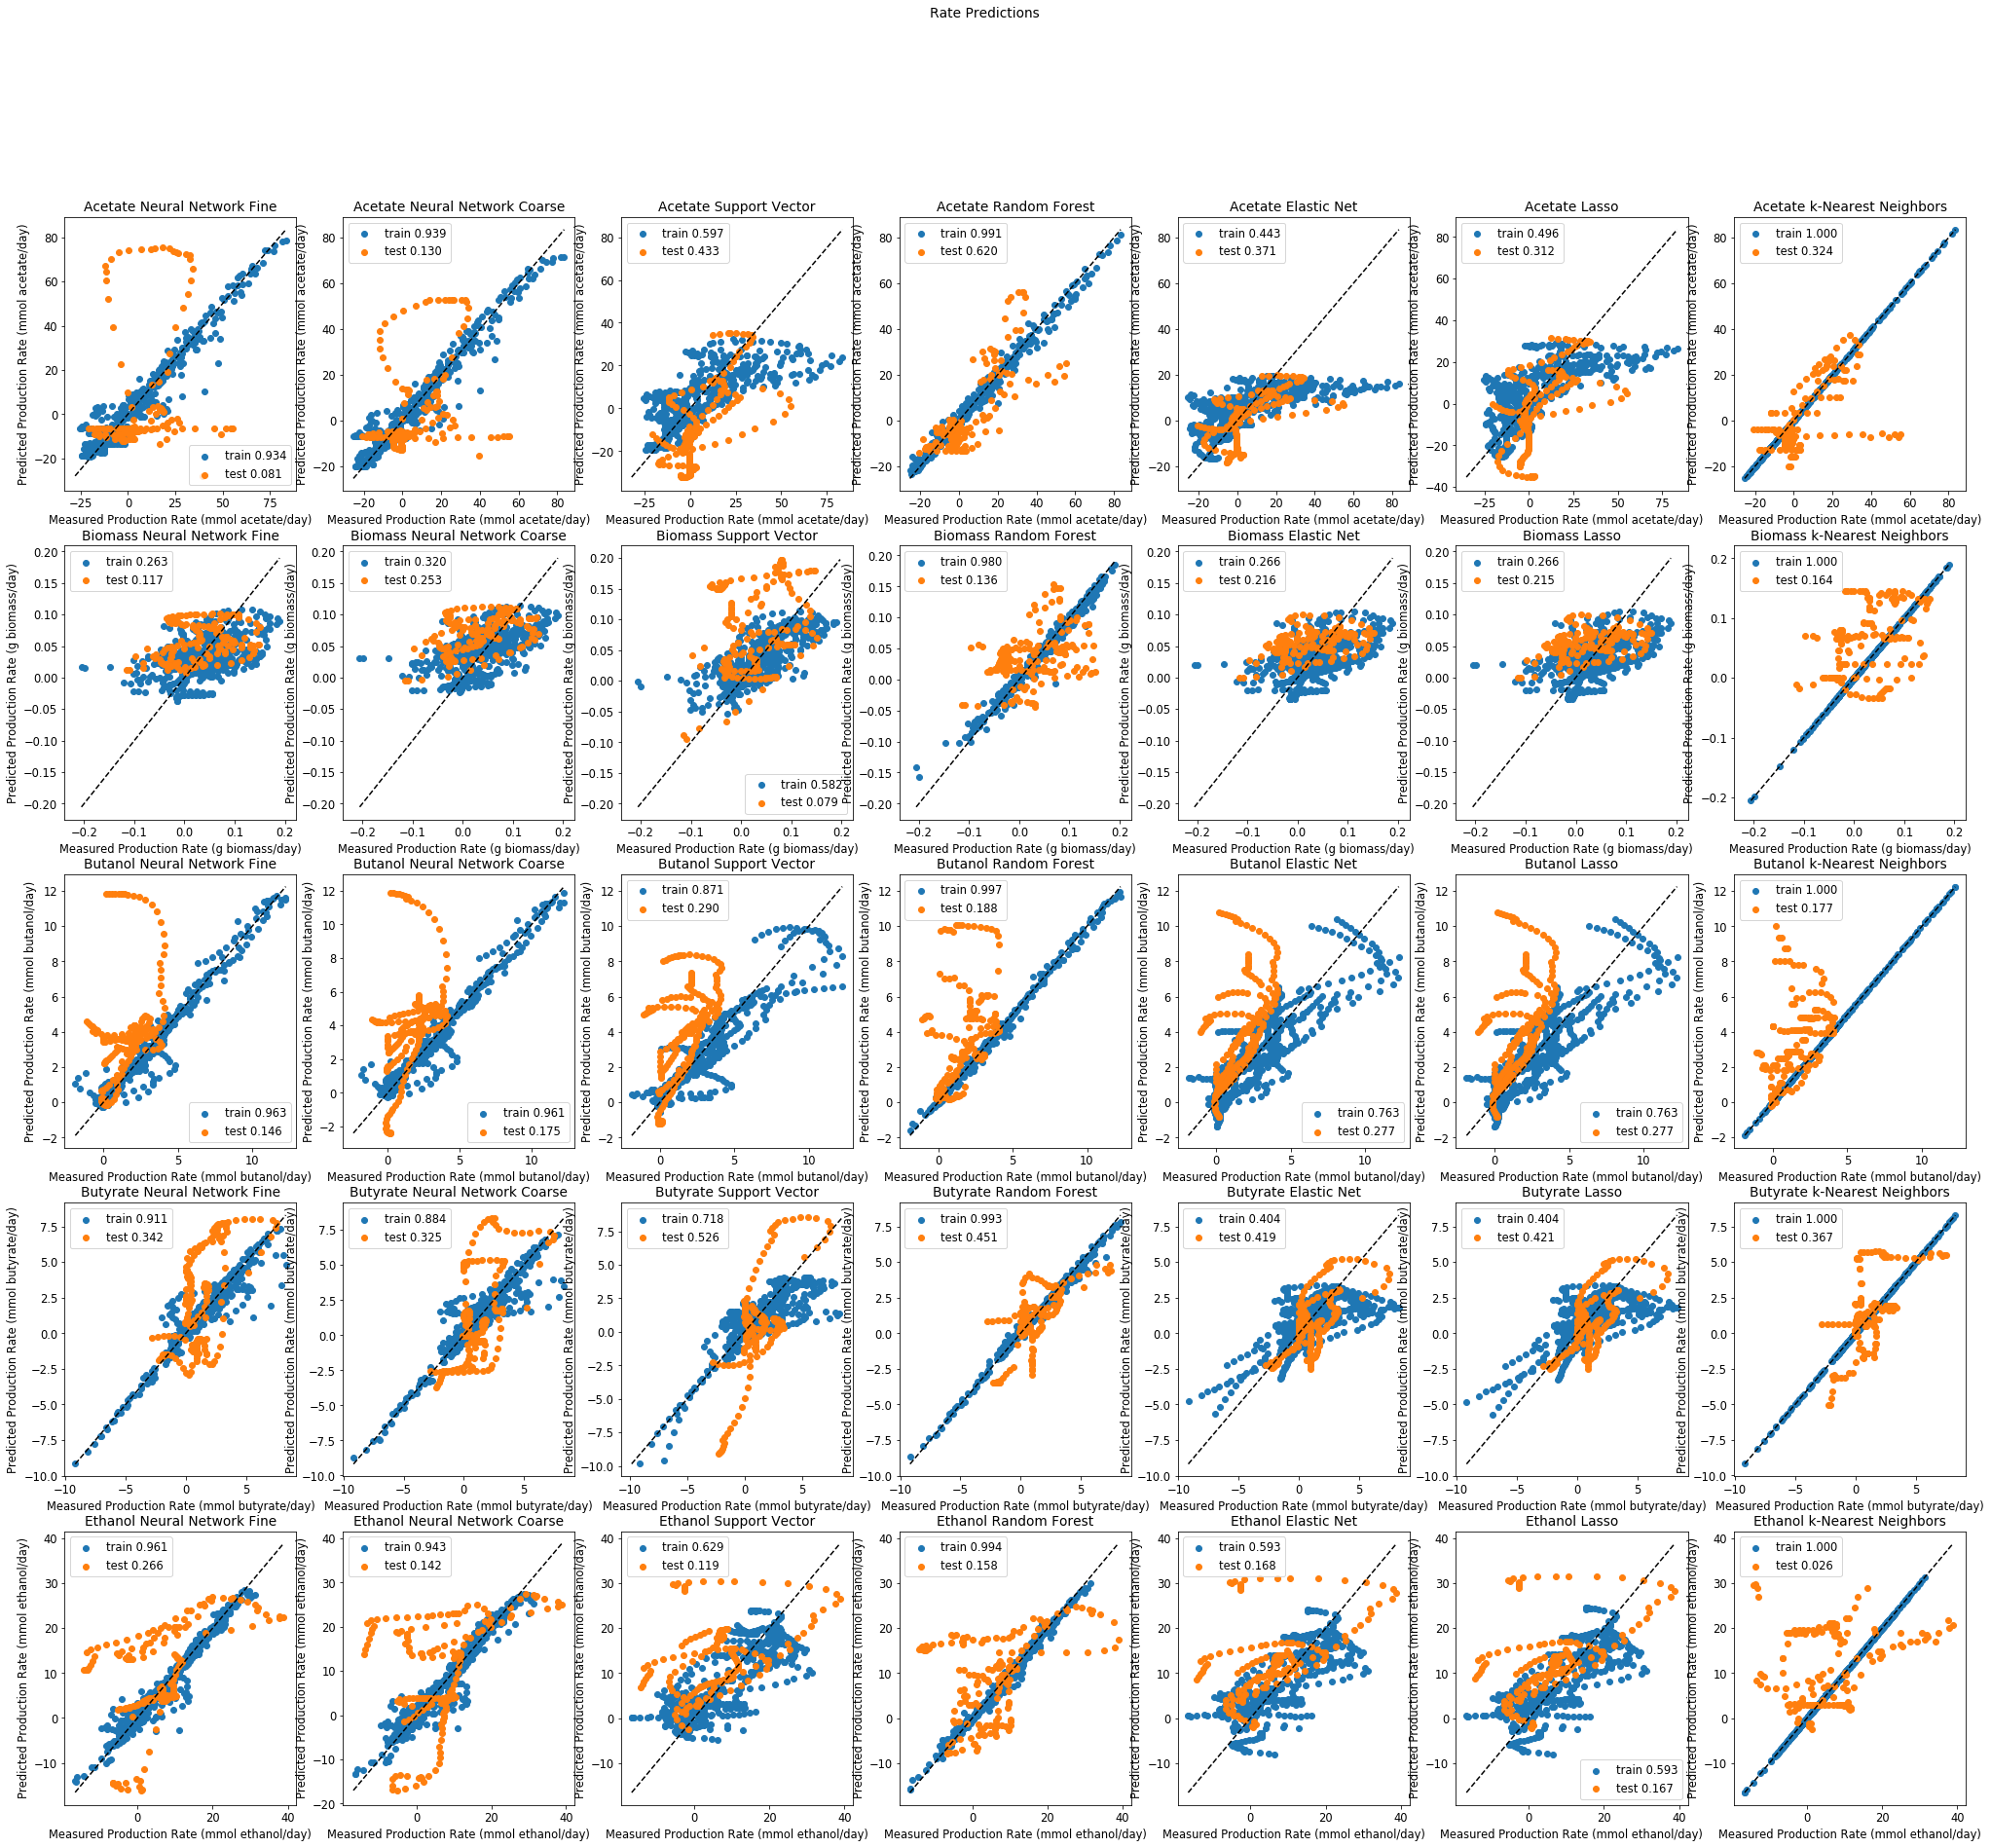

In [15]:
plt.rcParams.update({'font.size': 11.5})
fig, ax = plt.subplots(5, 7, figsize=(35, 30))
fig.suptitle(f'Rate Predictions')

algorithm_dictionary = {
    'nn_fine': 'Neural Network Fine',
    'nn_coarse': 'Neural Network Coarse',
    'svm_rbf': 'Support Vector', 
    'rf' : 'Random Forest',
    'en': 'Elastic Net', 
    'lasso' : 'Lasso',
    'knn': 'k-Nearest Neighbors'
}

for x_index, output in enumerate(['acetate', 'biomass', 'butanol', 'butyrate', 'ethanol']):
    train_r2_list = []
    test_r2_list = []
    for y_index, algorithm in enumerate(['nn_fine', 'nn_coarse', 'svm_rbf', 'rf', 'en', 'lasso', 'knn']):
 
        # Set title, x label, and y label of the subplot
        ax[x_index, y_index].title.set_text(f'{output.capitalize()} {algorithm_dictionary[algorithm]}')
        if output != 'biomass':
            ax[x_index, y_index].set_xlabel(f'Measured Production Rate (mmol {output}/day)')
            ax[x_index, y_index].set_ylabel(f'Predicted Production Rate (mmol {output}/day)')
        else:
            ax[x_index, y_index].set_xlabel(f'Measured Production Rate (g biomass/day)')
            ax[x_index, y_index].set_ylabel(f'Predicted Production Rate (g biomass/day)')
            
        # Plot training and test data by plotting predicted Production Rates vs measured Production Rates
        ax[x_index, y_index].scatter(train_prediction_df[f'{output} measured'], train_prediction_df[f'{output} {algorithm}'])
        ax[x_index, y_index].scatter(test_prediction_df[f'{output} measured'], test_prediction_df[f'{output} {algorithm}'])
        
        # ensure that all plots are square, so that 45 degree line looks the same in all plots
        minimum = min(pd.concat([
            train_prediction_df[f'{output} measured'],
            train_prediction_df[f'{output} {algorithm}'],
            test_prediction_df[f'{output} measured'],
            test_prediction_df[f'{output} {algorithm}']
        ], axis=0))
        maximum = max(pd.concat([
            train_prediction_df[f'{output} measured'],
            train_prediction_df[f'{output} {algorithm}'],
            test_prediction_df[f'{output} measured'],
            test_prediction_df[f'{output} {algorithm}']
        ], axis=0))
        
        # calculate train data r-squared
        measured_train_data = train_prediction_df[f'{output} measured']
        predicted_train_data = train_prediction_df[f'{output} {algorithm}']
        # could use scikitlearn's r-squared value
        # train_r2 = sklearn.metrics.r2_score(measured_train_data, predicted_train_data)
        _, _, train_r_value, _, _ = scipy.stats.linregress(measured_train_data, predicted_train_data)
        train_r2_list.append(train_r_value**2)

        # calculate test data r-squared
        measured_test_data = test_prediction_df[f'{output} measured']
        predicted_test_data = test_prediction_df[f'{output} {algorithm}']
        # could use scikitlearn's r-squared value
        # test_r2 = sklearn.metrics.r2_score(measured_test_data, predicted_test_data)
        _, _, test_r_value, _, _ = scipy.stats.linregress(measured_test_data, predicted_test_data)
        test_r2_list.append(test_r_value**2)
        
        # add legend to the plot
        ax[x_index, y_index].legend([f'train {train_r_value**2:.3f}', f'test {test_r_value**2:.3f}'])
        
        # plot the subplot
        ax[x_index, y_index].plot([minimum, maximum], [minimum, maximum], 'k--') #row=0, col=0

plt.savefig(f'../figures/scatter_plots.png', dpi=100)
plt.show()

### Plot bar graph of r squared values

ValueError: shape mismatch: objects cannot be broadcast to a single shape

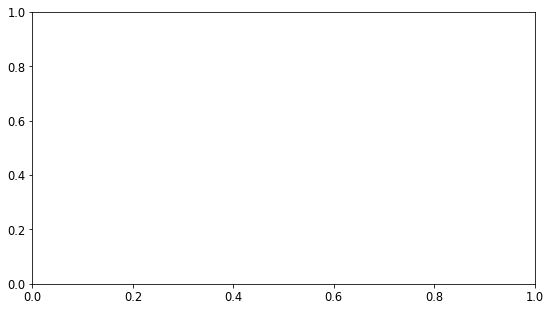

In [16]:
plt.rcParams.update({'font.size': 11.5})
for output in ['acetate', 'biomass', 'butanol', 'butyrate', 'ethanol']:
    train_r2_list = []
    test_r2_list = []
    for algorithm in ['nn_fine', 'nn_coarse', 'svm_rbf', 'rf', 'en', 'lasso', 'knn']:

        # Calculate training data r-squared
        measured_train_data = train_prediction_df[f'{output} measured']
        predicted_train_data = train_prediction_df[f'{output} {algorithm}']
        # could use scikitlearn's r-squared value
        # train_r2 = sklearn.metrics.r2_score(measured_train_data, predicted_train_data)
        _, _, train_r_value, _, _ = scipy.stats.linregress(measured_train_data, predicted_train_data)
        train_r2_list.append(train_r_value**2)

        # Calculate test data r-squared
        measured_test_data = test_prediction_df[f'{output} measured']
        predicted_test_data = test_prediction_df[f'{output} {algorithm}']
        # could use scikitlearn's r-squared value
        # test_r2 = sklearn.metrics.r2_score(measured_test_data, predicted_test_data)
        _, _, test_r_value, _, _ = scipy.stats.linregress(measured_test_data, predicted_test_data)
        test_r2_list.append(test_r_value**2)
    
    # define values to help with plotting
    x = np.arange(6)  # the label locations
    width = 0.25  # the width of the bars

    # plot training and testing r-squared values
    fig, ax = plt.subplots(figsize=(9,5))
    rects1 = ax.bar(x - .5 * width, train_r2_list,      width, label='Train')
    rects3 = ax.bar(x + .5 * width, test_r2_list, width, label='Test')

    # Add labels for title and custom x-axis tick labels, etc.
    ax.set_ylabel('r-squared Value')
    ax.set_title(f'{output.capitalize()} Prediction Quality')
    ax.set_xticks(x)
    ax.set_xticklabels(['Neural Net', 'Support Vector', 'Random Forest', 'Elastic Net', 'Lasso', 'K-nearest'])
    ax.legend()

    fig.tight_layout()
    plt.savefig(f'../figures/bar_graph_{output}.png', dpi=100)
#     plt.show()

### Make data frames to plot feature importance of metabolite and gases

In [17]:
features = ['acetate', 'biomass', 'butanol', 'butyrate', 'ethanol', 'CO', 'CO2', 'H2', 'flow rate']

metabolites = ['acetate', 'biomass', 'butanol', 'butyrate', 'ethanol']
gases = ['CO', 'CO2', 'H2', 'flow rate']

metabolite_feature_importance_list = []
gases_feature_importance_list = []

for output in ['acetate', 'biomass', 'butanol', 'butyrate', 'ethanol']:
    
    # get trained random forest model for the output
    model = trained_models[f'{output} rf']
    
    # get feature importance
    feature_importance_array = model.feature_importances_
    # print(feature_importance_array)
    
    # label feature importances
    feature_importance_dictionary = {feature: importance for feature, importance in zip(features, feature_importance_array)}
    
    # split dictionary into metabolites and gases and add the split dictionaries to lists
    metabolite_feature_importance_list.append({metabolite: feature_importance_dictionary[metabolite] for metabolite in metabolites})
    gases_feature_importance_list.append({gas: feature_importance_dictionary[gas] for gas in gases})
    
# convert list of dictionaries to dataframes
metabolite_feature_importance_df = pd.DataFrame(metabolite_feature_importance_list, index=metabolites)
gases_feature_importance_df = pd.DataFrame(gases_feature_importance_list, index=metabolites)

# display the dataframes
display(metabolite_feature_importance_df)
display(gases_feature_importance_df)


,acetate,biomass,butanol,butyrate,ethanol
acetate,0.040397,0.054337,0.133171,0.615479,0.104507
biomass,0.156565,0.133471,0.252108,0.238948,0.123552
butanol,0.047869,0.142270,0.029448,0.591234,0.049491
butyrate,0.118611,0.103150,0.139186,0.379655,0.163962
ethanol,0.040610,0.646771,0.066401,0.092141,0.098825


,CO,CO2,H2,flow rate
acetate,0.002324,0.010359,0.003468,0.012009
biomass,0.013955,0.010412,0.013725,0.011884
butanol,0.004823,0.002543,0.103555,0.017051
butyrate,0.080002,0.001682,0.006985,0.003659
ethanol,0.006168,0.007175,0.003125,0.010351


### Plot metabolite feature importance

,acetate,biomass,butanol,butyrate,ethanol
acetate,0.040397,0.054337,0.133171,0.615479,0.104507
biomass,0.156565,0.133471,0.252108,0.238948,0.123552
butanol,0.047869,0.142270,0.029448,0.591234,0.049491
butyrate,0.118611,0.103150,0.139186,0.379655,0.163962
ethanol,0.040610,0.646771,0.066401,0.092141,0.098825


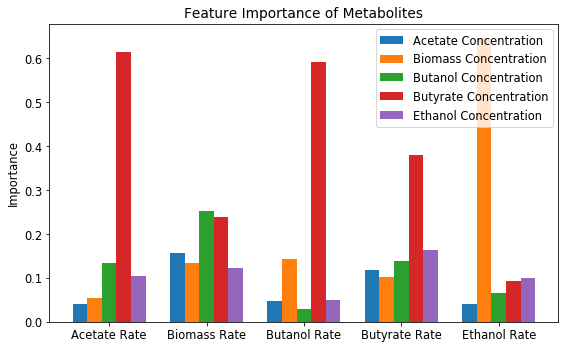

In [18]:
display(metabolite_feature_importance_df)

# This helps with formatting 
x = np.arange(5)  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(8,5))

for counter, (index, row) in enumerate(metabolite_feature_importance_df.transpose().iterrows()):
    output_feature_importances = list(row)
    
    rects = ax.bar(x - 0.3 + 0.15*counter, output_feature_importances , width, label=f'{index.capitalize()} Concentration')

# # Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(f'Importance')

ax.set_title(f'Feature Importance of Metabolites')
ax.set_xticks(x)
labels = ['Acetate Rate', 'Biomass Rate', 'Butanol Rate', 'Butyrate Rate', 'Ethanol Rate']
ax.set_xticklabels(labels)
ax.legend()
# ax.set_yscale('log')

fig.tight_layout()
plt.savefig(f'../figures/feature_importance_metabolites.png', dpi=100)
plt.show()

### Plot gases feature importance

,CO,CO2,H2,flow rate
acetate,0.002324,0.010359,0.003468,0.012009
biomass,0.013955,0.010412,0.013725,0.011884
butanol,0.004823,0.002543,0.103555,0.017051
butyrate,0.080002,0.001682,0.006985,0.003659
ethanol,0.006168,0.007175,0.003125,0.010351


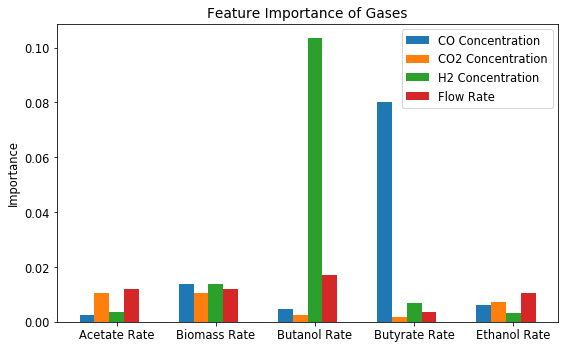

In [19]:
display(gases_feature_importance_df)

# This helps with formatting 
x = np.arange(5)  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(8,5))

for counter, (index, row) in enumerate(gases_feature_importance_df.transpose().iterrows()):
    output_feature_importances = list(row)
    if index != 'flow rate':
        index = index + ' Concentration' 
    else:
        index = 'Flow Rate'
    rects = ax.bar(x - 0.3 + 0.15*counter, output_feature_importances , width, label=f'{index}')

# # Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(f'Importance')

ax.set_title(f'Feature Importance of Gases')
ax.set_xticks(x)
labels = ['Acetate Rate', 'Biomass Rate', 'Butanol Rate', 'Butyrate Rate', 'Ethanol Rate']
ax.set_xticklabels(labels)
ax.legend()
# ax.set_yscale('log')

fig.tight_layout()
plt.savefig(f'../figures/feature_importance_gases.png', dpi=100)
plt.show()

### Plot feature importance of each gas for each output

,CO,CO2,H2,flow rate
acetate,0.002324,0.010359,0.003468,0.012009
biomass,0.013955,0.010412,0.013725,0.011884
butanol,0.004823,0.002543,0.103555,0.017051
butyrate,0.080002,0.001682,0.006985,0.003659
ethanol,0.006168,0.007175,0.003125,0.010351


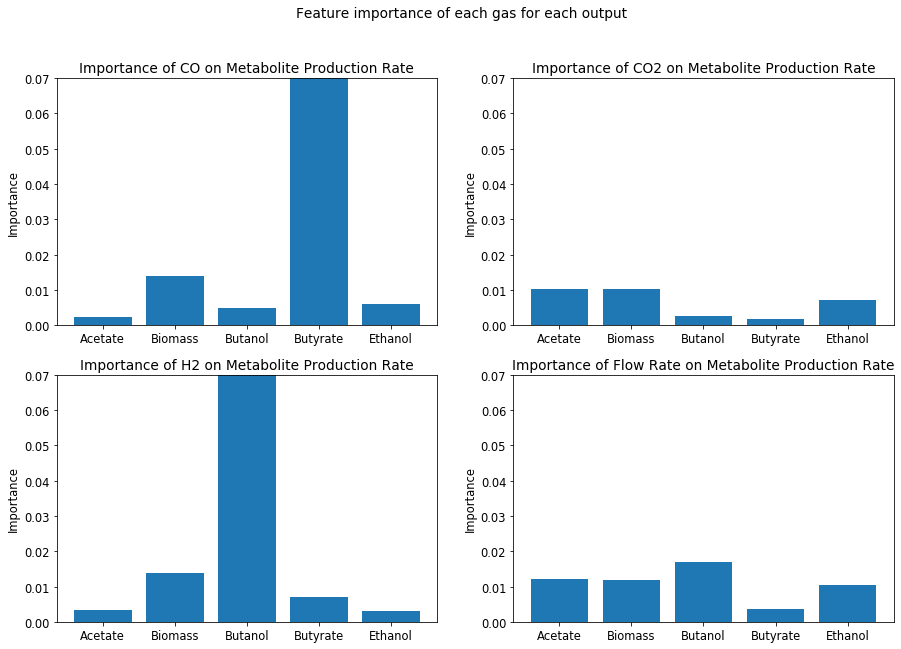

In [20]:
display(gases_feature_importance_df)

plt.rcParams.update({'font.size': 11.5})
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(f'Feature importance of each gas for each output')

labels = [label.capitalize() for label in gases_feature_importance_df.index]

ax[0,0].title.set_text(f'Importance of CO on Metabolite Production Rate')
ax[0,0].set_ylabel(f'Importance')
ax[0,0].axis(ymin=0.0,ymax=0.07)
rects = ax[0,0].bar(labels, gases_feature_importance_df['CO'])

ax[0,1].title.set_text(f'Importance of CO2 on Metabolite Production Rate')
ax[0,1].set_ylabel(f'Importance')
ax[0,1].axis(ymin=0.0,ymax=0.07)
rects = ax[0,1].bar(labels, gases_feature_importance_df['CO2'])

ax[1,0].title.set_text(f'Importance of H2 on Metabolite Production Rate')
ax[1,0].set_ylabel(f'Importance')
ax[1,0].axis(ymin=0.0,ymax=0.07)
rects = ax[1,0].bar(labels, gases_feature_importance_df['H2'])

ax[1,1].title.set_text(f'Importance of Flow Rate on Metabolite Production Rate')
ax[1,1].set_ylabel(f'Importance')
ax[1,1].axis(ymin=0.0,ymax=0.07)
rects = ax[1,1].bar(labels, gases_feature_importance_df['flow rate'])

plt.savefig(f'../figures/feature_importance_per_gas.png', dpi=100)

plt.show()

### Save gases_feature_importance as csv

In [21]:
gases_feature_importance_df.to_csv('../data/gases_importance.csv')

### -- Stopping here --